In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'forestfires.csv'
df = pd.read_csv(file_path)

# Remove the specified columns
df.drop(columns=['rain', 'X', 'Y', 'day'], inplace=True)

# Convert months to a binary summer category
def is_summer(month):
    return int(month in ['jun', 'jul', 'aug'])

df['is_summer'] = df['month'].apply(is_summer)
df.drop(columns='month', inplace=True)

# Function to remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df[columns] < lower_bound) | (df[columns] > upper_bound)).any(axis=1)]

# Remove outliers
numeric_features = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'area']
df = remove_outliers_iqr(df, numeric_features)

# Apply log transformation to the target variable
df['log_area'] = np.log1p(df['area'])  # log1p is used to handle log(0)

# Create new features
df['temp_RH_interaction'] = df['temp'] * df['RH']
df['wind_ISI_interaction'] = df['wind'] * df['ISI']

# Generate polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[numeric_features[:-1]])
poly_feature_names = [f"poly_{i}" for i in range(poly_features.shape[1])]

# Combine polynomial features with the original data
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names)
df = pd.concat([df, df_poly], axis=1)

# Check for and handle NaN or infinite values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Split the data into features and target
X = df.drop(columns=['area', 'log_area'])
y = df['log_area']

# Normalize the numeric features
scaler = StandardScaler()
X[numeric_features[:-1]] = scaler.fit_transform(X[numeric_features[:-1]])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost model
xgb_model = xgb.XGBRegressor()

# Define the hyperparameter grid for XGBoost
param_grid_xgb = {
    'colsample_bytree': np.linspace(0.05, 0.1, 10),
    'gamma': np.linspace(0.1, 0.2, 10),
    'learning_rate': np.linspace(0.07, 0.1, 10),
    'max_depth': range(9, 12),
    'n_estimators': range(280, 300, 5),
    'subsample': np.linspace(0.55, 0.65, 10)
}

# Perform RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_grid_xgb, 
    n_iter=100,  # Number of iterations
    cv=5, 
    scoring='neg_mean_squared_error', 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)
random_search_xgb.fit(X_train, y_train)

# Get the best XGBoost model
best_xgb_model = random_search_xgb.best_estimator_

# Predict on the test set using the best XGBoost model
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the XGBoost model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Best Parameters: {random_search_xgb.best_params_}")
print(f"XGBoost Test RMSE: {rmse_xgb}")
print(f"XGBoost Test MAE: {mae_xgb}")
print(f"XGBoost Test R²: {r2_xgb}")

# Define the RandomForest model
rf_model = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid for RandomForest
param_grid_rf = {
    'max_depth': range(8, 11),
    'min_samples_leaf': range(1, 2),
    'min_samples_split': range(2, 5),
    'n_estimators': range(230, 250, 5)
}

# Perform RandomizedSearchCV for RandomForest
random_search_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=param_grid_rf,
    n_iter=60,  # Number of iterations
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search_rf.fit(X_train, y_train)

# Get the best RandomForest model
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the RandomForest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Best Parameters: {random_search_rf.best_params_}")
print(f"Random Forest Test RMSE: {rmse_rf}")
print(f"Random Forest Test MAE: {mae_rf}")
print(f"Random Forest Test R²: {r2_rf}")

# Ensemble method (Stacking Regressor)
estimators = [
    ('xgb', best_xgb_model),
    ('rf', best_rf_model)
]
stacking_regressor = StackingRegressor(
    estimators=estimators, 
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

# Train the stacking regressor
stacking_regressor.fit(X_train, y_train)

# Predict on the test set using the stacking regressor
y_pred_ensemble = stacking_regressor.predict(X_test)

# Evaluate the stacking regressor
mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
rmse_ensemble = np.sqrt(mse_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print(f"Stacking Regressor Test RMSE: {rmse_ensemble}")
print(f"Stacking Regressor Test MAE: {mae_ensemble}")
print(f"Stacking Regressor Test R²: {r2_ensemble}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
XGBoost Best Parameters: {'subsample': 0.5833333333333334, 'n_estimators': 285, 'max_depth': 9, 'learning_rate': 0.09666666666666668, 'gamma': 0.2, 'colsample_bytree': 0.061111111111111116}
XGBoost Test RMSE: 0.8202160648283384
XGBoost Test MAE: 0.6459818479972383
XGBoost Test R²: 0.07725186895227376
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 36 is smaller than n_iter=60. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Random Forest Best Parameters: {'n_estimators': 240, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 9}
Random Forest Test RMSE: 0.7845424278920019
Random Forest Test MAE: 0.6447761369174854
Random Forest Test R²: 0.1557724857949916
Stacking Regressor Test RMSE: 0.8102542057620714
Stacking Regressor Test MAE: 0.6393904377145178
Stacking Regressor Test R²: 0.09953005926861791


In [3]:
# Baseline model: Mean prediction
y_pred_baseline = np.mean(y_train)

# Calculate baseline metrics
baseline_rmse = np.sqrt(mean_squared_error(y_test, [y_pred_baseline] * len(y_test)))
baseline_mae = mean_absolute_error(y_test, [y_pred_baseline] * len(y_test))
baseline_r2 = r2_score(y_test, [y_pred_baseline] * len(y_test))

print(f"Baseline Test RMSE: {baseline_rmse}")
print(f"Baseline Test MAE: {baseline_mae}")
print(f"Baseline Test R²: {baseline_r2}")


Baseline Test RMSE: 0.8539066866291549
Baseline Test MAE: 0.730910715957559
Baseline Test R²: -0.00010928814849053836


c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


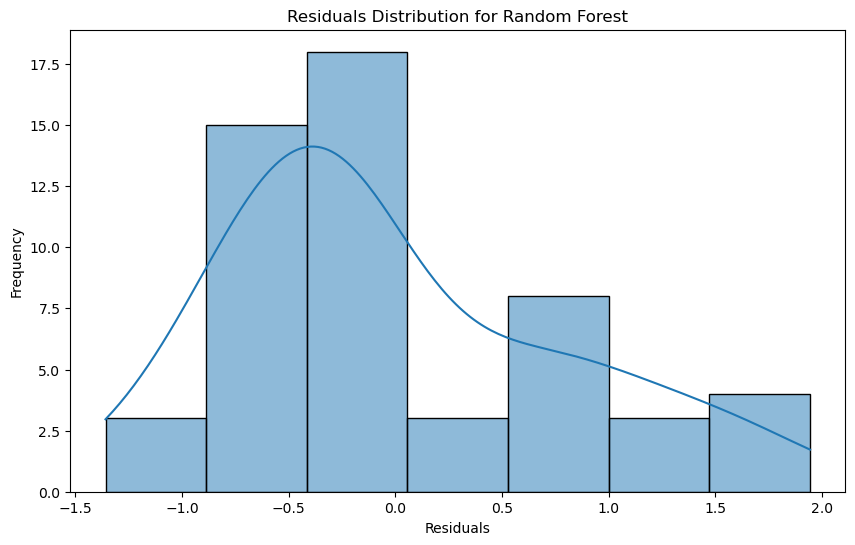

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(y_test - y_pred_rf, kde=True)
plt.title('Residuals Distribution for Random Forest')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [6]:
import pandas as pd
import numpy as np

# Assuming y_test and y_pred_rf are the actual and predicted values respectively
residuals = y_test - y_pred_rf

# Identify the largest residuals
outliers = np.abs(residuals) > 1.5
outlier_data = pd.DataFrame({'Actual': y_test[outliers], 'Predicted': y_pred_rf[outliers], 'Residual': residuals[outliers]})

# Display the DataFrame
from IPython.display import display
display(outlier_data)


,Actual,Predicted,Residual
197,2.489894,0.957395,1.532499
254,2.428336,0.725569,1.702768
311,2.727199,0.784097,1.943102


Outlier Data Points:
       Actual  Predicted  Residual
197  2.489894   0.957395  1.532499
254  2.428336   0.725569  1.702768
311  2.727199   0.784097  1.943102


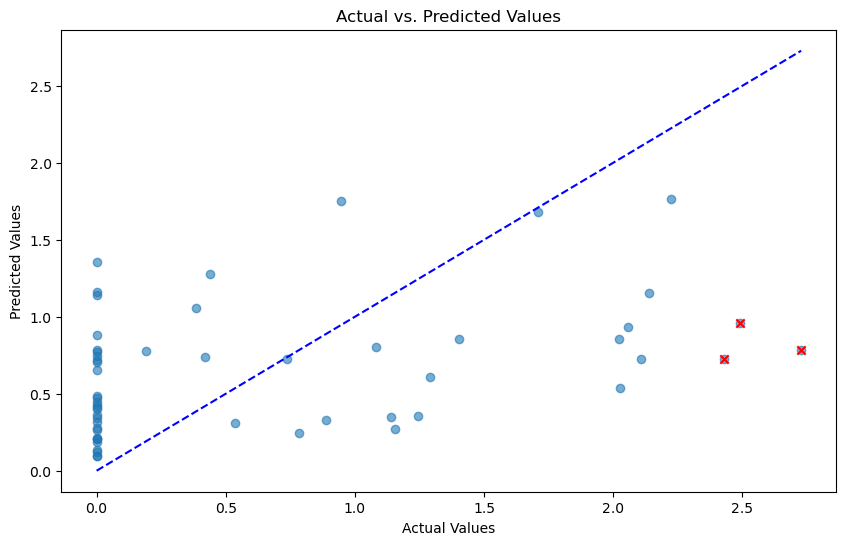

c:\Users\paulo\anaconda3\envs\pytorch_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


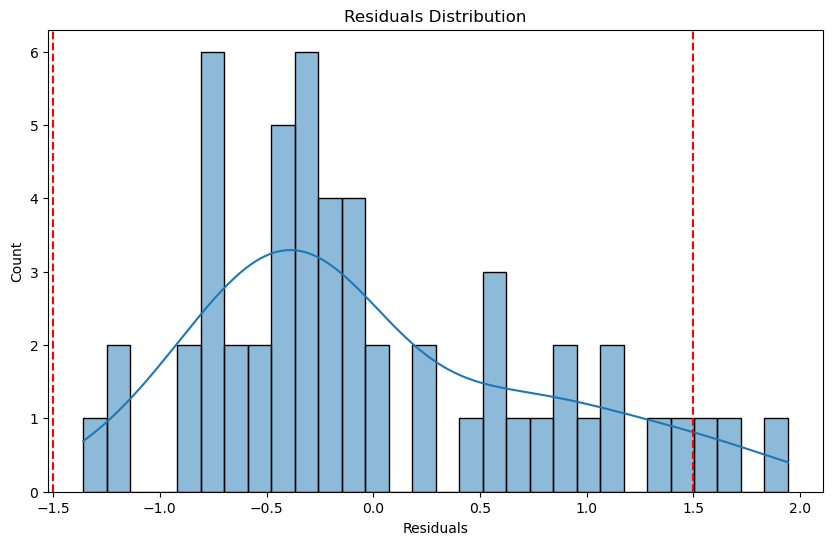

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_test and y_pred_rf are the actual and predicted values respectively
residuals = y_test - y_pred_rf

# Identify the largest residuals
outliers = np.abs(residuals) > 1.5
outlier_data = pd.DataFrame({'Actual': y_test[outliers], 'Predicted': y_pred_rf[outliers], 'Residual': residuals[outliers]})

# Display the DataFrame
print("Outlier Data Points:")
print(outlier_data)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.scatter(outlier_data['Actual'], outlier_data['Predicted'], color='red', marker='x')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=1.5, color='red', linestyle='--')
plt.axvline(x=-1.5, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.title('Residuals Distribution')
plt.show()
